# Composite Water Stress Index (CWSI) 

This project aims to develop a **Composite Water Stress Index (CWSI)** that provides a single, comparable score representing a country’s water usage, scarcity and sustainability profile. By integrating multiple dimensions such as total consumption, per capita use, groundwater depletion and rainfall. The index offers a multidimensional perspective on how water is being used and conserved globally. 

In [23]:
# All Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### Step 1 : Loading & Exploring the Data

In [7]:
df = pd.read_csv("global_water_consumption.csv")

# View the first few rows
print(df.head())

# Basic summary
print(df.describe())
print(df.info())

     Country  Year  Total Water Consumption (Billion Cubic Meters)  \
0  Indonesia  2022                                          895.15   
1  Indonesia  2024                                          502.89   
2      Spain  2000                                          843.39   
3     Canada  2021                                          803.34   
4     Brazil  2022                                          416.40   

   Per Capita Water Use (Liters per Day) Water Scarcity Level  \
0                                 489.73                  Low   
1                                 311.95                 High   
2                                 440.09               Medium   
3                                 478.98                 High   
4                                 353.91                 High   

   Agricultural Water Use (%)  Industrial Water Use (%)  \
0                       20.78                     13.75   
1                       48.51                      8.44   
2          

### Step 2: Preprocessing & Cleaning

In [8]:
# Check for nulls
print(df.isnull().sum())

Country                                           0
Year                                              0
Total Water Consumption (Billion Cubic Meters)    0
Per Capita Water Use (Liters per Day)             0
Water Scarcity Level                              0
Agricultural Water Use (%)                        0
Industrial Water Use (%)                          0
Household Water Use (%)                           0
Rainfall Impact (Annual Precipitation in mm)      0
Groundwater Depletion Rate (%)                    0
dtype: int64


Luckily, our dataset does not contain any missing values, so we can safely skip the data imputation step. However, to demonstrate good data hygiene practices, I have included the code that can be used in case missing values were present.

Given that our dataset consists of 5,000 rows, dropping a few incomplete rows would not significantly affect the overall analysis. Filling missing values with column averages is not ideal in this context, as each country has distinct water usage patterns and environmental characteristics. Using mean imputation could introduce inaccuracies or misrepresentations in country-level comparisons.

In [9]:
# Print total rows before
print(f"Total rows before dropping missing values: {len(df)}")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop rows with any missing values
df.dropna(inplace=True)

# Print total rows after
print(f"\nTotal rows after dropping missing values: {len(df)}")

# Confirm no missing values remain
print("Missing values per column (after cleanup):")
print(df.isnull().sum())


Total rows before dropping missing values: 5000
Missing values per column:
Country                                           0
Year                                              0
Total Water Consumption (Billion Cubic Meters)    0
Per Capita Water Use (Liters per Day)             0
Water Scarcity Level                              0
Agricultural Water Use (%)                        0
Industrial Water Use (%)                          0
Household Water Use (%)                           0
Rainfall Impact (Annual Precipitation in mm)      0
Groundwater Depletion Rate (%)                    0
dtype: int64

Total rows after dropping missing values: 5000
Missing values per column (after cleanup):
Country                                           0
Year                                              0
Total Water Consumption (Billion Cubic Meters)    0
Per Capita Water Use (Liters per Day)             0
Water Scarcity Level                              0
Agricultural Water Use (%)               

### Categorical Encoding

In our dataset, we identified two columns containing categorical values that need to be encoded to numerical format before performing further analysis:

- **Water Scarcity Level** (`High`, `Medium`, `Low`)
- **Country** (20 unique country names)

---

### 🔸 Encoding Strategy

- **Water Scarcity Level** has an inherent order, so we use **Ordinal Encoding**:
  - `High` → 3  
  - `Medium` → 2  
  - `Low` → 1  

  This preserves the logical ranking of water scarcity severity.

- **Country** does not have any intrinsic order, so we apply **One-Hot Encoding**.  
  This technique creates a new binary column for each country, ensuring that the model does not mistakenly assume any ordinal relationship between countries.

---

This encoding step allows us to convert all categorical variables into numerical format, making them compatible with normalization, clustering, and other analytical techniques later in the pipeline.



In [10]:
# --- Ordinal Encoding for 'Water Scarcity Level' ---
scarcity_map = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}
df['Water Scarcity Level'] = df['Water Scarcity Level'].map(scarcity_map)

# --- Preserve original 'Country' column ---
df['Country_Label'] = df['Country']  # Copy for visualization

# --- One-Hot Encoding for modeling ---
df = pd.get_dummies(df, columns=['Country'])

# --- Check the result ---
print(df.head())
print(f"Shape after encoding: {df.shape}")


   Year  Total Water Consumption (Billion Cubic Meters)  \
0  2022                                          895.15   
1  2024                                          502.89   
2  2000                                          843.39   
3  2021                                          803.34   
4  2022                                          416.40   

   Per Capita Water Use (Liters per Day)  Water Scarcity Level  \
0                                 489.73                     1   
1                                 311.95                     3   
2                                 440.09                     2   
3                                 478.98                     3   
4                                 353.91                     3   

   Agricultural Water Use (%)  Industrial Water Use (%)  \
0                       20.78                     13.75   
1                       48.51                      8.44   
2                       25.16                     31.70   
3           

### Step 3 : Multivariate Analysis

In [11]:
# Select the columns to normalize
numerical_cols = ['Total Water Consumption (Billion Cubic Meters)', 
                  'Per Capita Water Use (Liters per Day)', 
                  'Agricultural Water Use (%)', 
                  'Industrial Water Use (%)', 
                  'Water Scarcity Level',
                  'Household Water Use (%)', 
                  'Rainfall Impact (Annual Precipitation in mm)', 
                  'Groundwater Depletion Rate (%)']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply normalization to the selected columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Check the result
print(df.head())

   Year  Total Water Consumption (Billion Cubic Meters)  \
0  2022                                        0.894375   
1  2024                                        0.498004   
2  2000                                        0.842072   
3  2021                                        0.801603   
4  2022                                        0.410608   

   Per Capita Water Use (Liters per Day)  Water Scarcity Level  \
0                               0.977237                   0.0   
1                               0.582048                   1.0   
2                               0.866892                   0.5   
3                               0.953341                   1.0   
4                               0.675321                   1.0   

   Agricultural Water Use (%)  Industrial Water Use (%)  \
0                    0.012838                  0.194444   
1                    0.475158                  0.076444   
2                    0.085862                  0.593333   
3           

In [12]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply standardization to the selected columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Check the result
print(df.head())

   Year  Total Water Consumption (Billion Cubic Meters)  \
0  2022                                        1.377109   
1  2024                                       -0.002003   
2  2000                                        1.195131   
3  2021                                        1.054322   
4  2022                                       -0.306085   

   Per Capita Water Use (Liters per Day)  Water Scarcity Level  \
0                               1.645835             -1.224017   
1                               0.276616              1.208933   
2                               1.263520             -0.007542   
3                               1.563041              1.208933   
4                               0.599782              1.208933   

   Agricultural Water Use (%)  Industrial Water Use (%)  \
0                   -1.695886                 -1.087913   
1                   -0.101845                 -1.500429   
2                   -1.444105                  0.306561   
3           

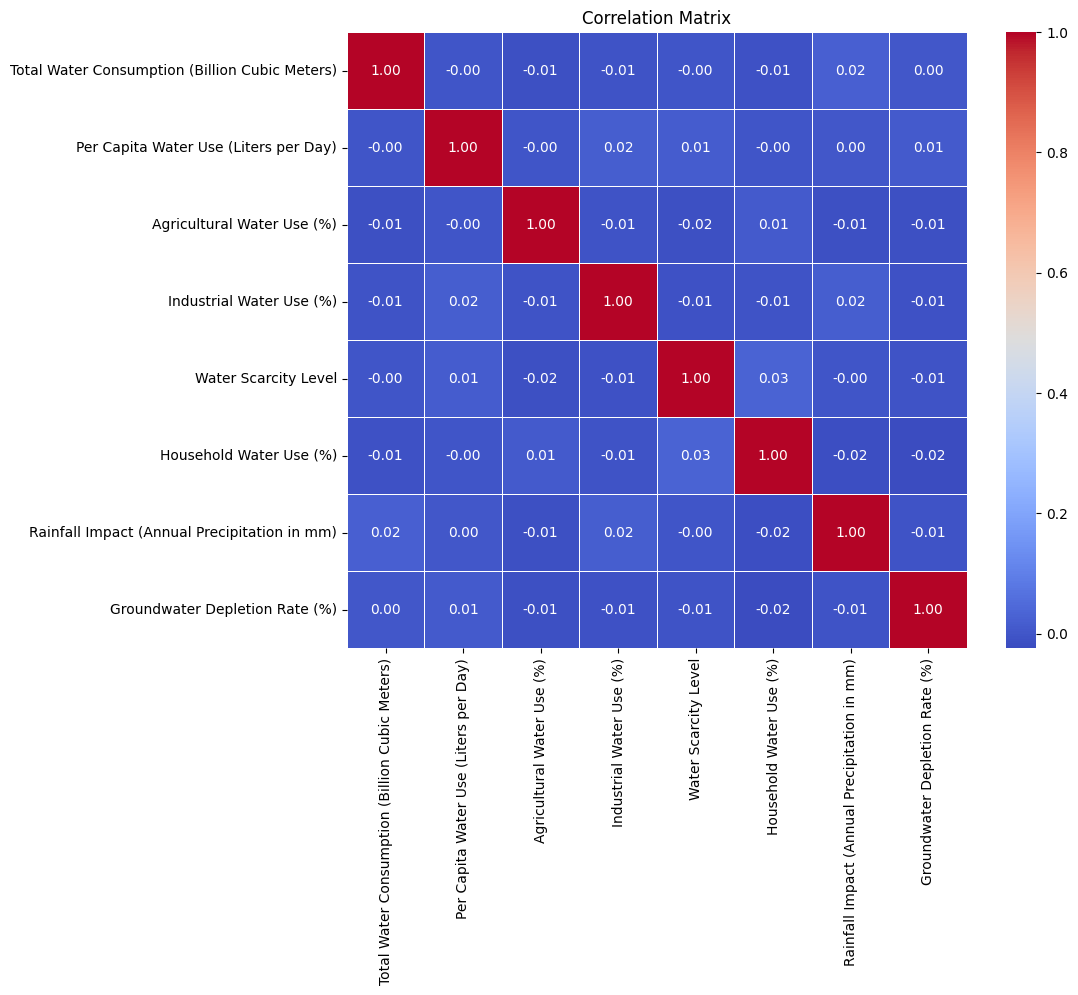

In [13]:
# Compute the correlation matrix
corr = df[numerical_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

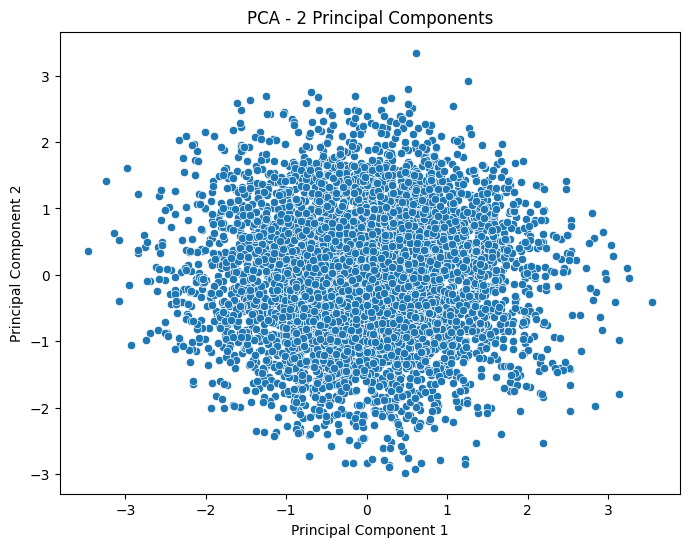

Explained variance ratio: [0.13212465 0.12875718 0.12758768 0.12705064 0.12326469 0.12140684
 0.12035974]


In [20]:
# Apply PCA
pca = PCA(n_components=7)  # Reduce to 2 components for visualization
principal_components = pca.fit_transform(df[numerical_cols])

# Create a DataFrame with the two principal components
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])

# Visualize the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pc_df['PC1'], y=pc_df['PC2'])
plt.title('PCA - 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Variance explained by each principal component
print("Explained variance ratio:", pca.explained_variance_ratio_)

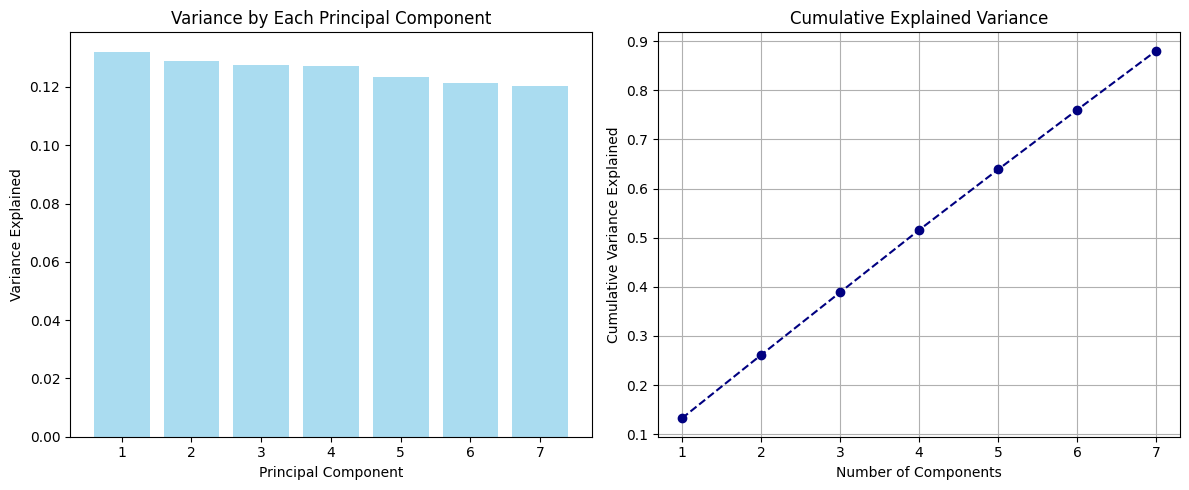

In [ ]:
# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

plt.figure(figsize=(12, 5))

# Individual explained variance
plt.subplot(1, 2, 1)
plt.bar(range(1, 8), explained_var, alpha=0.7, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance by Each Principal Component')
plt.xticks(range(1, 8))

# Cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, 8), cumulative_var, marker='o', linestyle='--', color='navy')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Explained Variance')
plt.xticks(range(1, 8))

plt.grid(True)

plt.tight_layout()
plt.show()

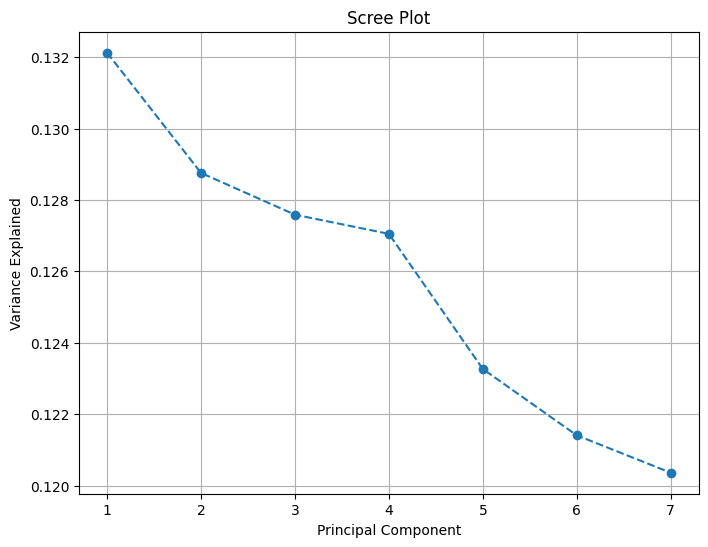

In [25]:
# Get the eigenvalues (explained variances) from PCA
explained_variance = pca.explained_variance_ratio_

# Create the Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(np.arange(1, len(explained_variance) + 1, 1))
plt.grid(True)
plt.show()

#### Principal Component Analysis (PCA) Summary

To better understand the structure of our data, we applied Principal Component Analysis (PCA) on the 7 numerical features. Below is an interpretation of the PCA results:

##### Variance by Each Principal Component (Left Plot)

- Each principal component (PC1 to PC7) explains approximately 12–13% of the total variance.
- This suggests that the information is evenly spread across all components, with no single component dominating.
- All features contribute meaningfully to the variance, indicating low redundancy among them.

##### Cumulative Explained Variance (Right Plot)

The cumulative variance plot shows how much total variance is explained as we add more components:

- 2 components explain ~26% of the variance.
- 5 components explain ~63–65%.
- 7 components explain ~88%.

The curve increases gradually without a sharp "elbow," implying no obvious cut-off point for dimensionality reduction.

##### Key Takeaways

- For visualization, using the first 2 components is acceptable, even if they explain only a small portion of the variance (~26%).
- For dimensionality reduction, retaining 5–7 components is advisable:
  - 5 components provide a balance between data compression and information retention.
  - 7 components retain most of the variance (88%) and may be preferable if minimizing information loss is critical.